In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from pathlib import Path
import shutil
import random
import shutil
from pathlib import Path
import os
import shutil
import random
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [3]:
train_path = r"C:\Users\DELL\vs_code\Plant_dieases\PlantVillageDataset\train_val_test\train"
val_path = r"C:\Users\DELL\vs_code\Plant_dieases\PlantVillageDataset\train_val_test\val"
test_path = r"C:\Users\DELL\vs_code\Plant_dieases\PlantVillageDataset\train_val_test\test"

IMAGE_SIZE = 256
BATCH_SIZE = 32



In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 14437 files belonging to 15 classes.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2073 files belonging to 15 classes.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4128 files belonging to 15 classes.


In [7]:
class_names = train_ds.class_names
print("Number of classes:", len(class_names))
print("Class names:")
for name in class_names:
    print(name)


Number of classes: 15
Class names:
Pepper__bell___Bacterial_spot
Pepper__bell___healthy
Potato___Early_blight
Potato___Late_blight
Potato___healthy
Tomato_Bacterial_spot
Tomato_Early_blight
Tomato_Late_blight
Tomato_Leaf_Mold
Tomato_Septoria_leaf_spot
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato__Target_Spot
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Tomato_mosaic_virus
Tomato_healthy


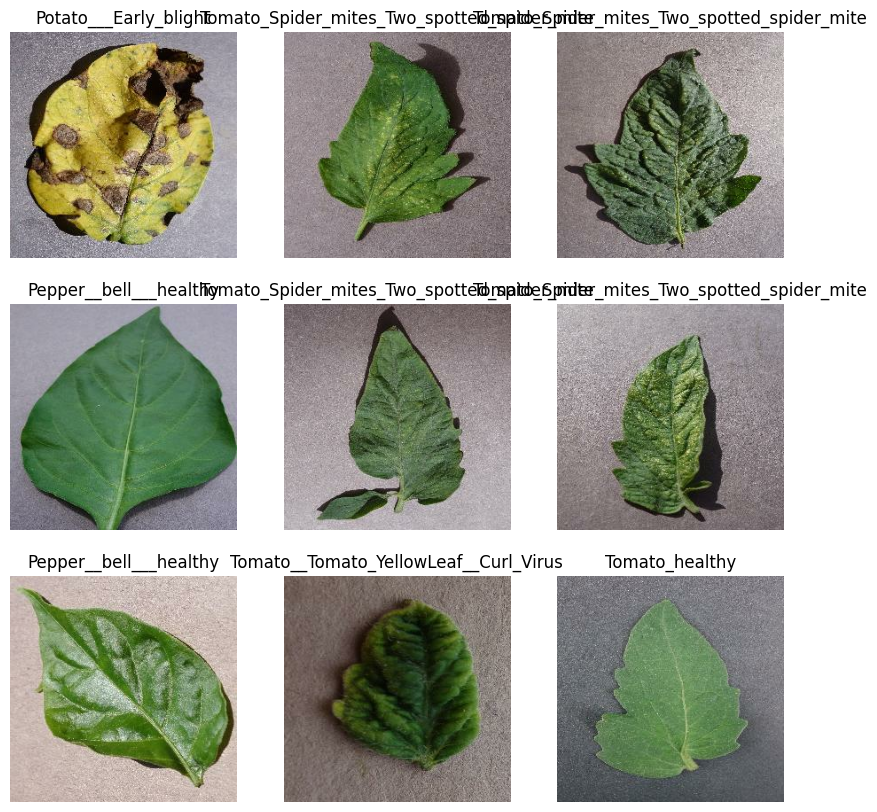

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):   # use raw dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [10]:
#data agumentation
data_agumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [11]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [14]:
n_classes=15

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

callbacks = [early_stop, reduce_lr, checkpoint]


In [14]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_agumentation,

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])


In [15]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [1]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


NameError: name 'model' is not defined

In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [10]:
model = load_model("best_model.h5")

In [11]:
model.evaluate(test_ds)

129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9128 - loss: 0.3352


[0.3351648151874542, 0.9127907156944275]

In [19]:
model.evaluate(val_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.9127 - loss: 0.3371


[0.3370598256587982, 0.9126869440078735]

In [20]:
model.save("plant_disease_model.keras")

In [21]:
model = tf.keras.models.load_model("plant_disease_model.keras")

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)


In [20]:
y_pred = np.argmax(model.predict(test_ds), axis=1)

129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 330ms/step


In [62]:
print(classification_report(y_true, y_pred, target_names=class_names))


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.86      0.93       200
                     Pepper__bell___healthy       0.98      0.97      0.97       296
                      Potato___Early_blight       0.88      0.97      0.92       200
                       Potato___Late_blight       0.90      0.87      0.88       200
                           Potato___healthy       0.96      0.77      0.85        30
                      Tomato_Bacterial_spot       0.98      0.95      0.96       426
                        Tomato_Early_blight       0.83      0.87      0.85       200
                         Tomato_Late_blight       0.93      0.87      0.90       382
                           Tomato_Leaf_Mold       0.93      0.94      0.93       190
                  Tomato_Septoria_leaf_spot       0.90      0.94      0.92       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.89      0.78

In [63]:
import json

In [64]:
with open("class_names.json","w") as f:
    json.dump(class_names,f)

In [15]:
img = tf.keras.utils.load_img(r"C:\Users\DELL\vs_code\Plant_dieases\PlantVillageDataset\train_val_test\test\Pepper__bell___healthy\0b796b7a-dfc8-47f7-9970-8373263c6408___JR_HL 5948.JPG", target_size=(256,256))

In [29]:
img = tf.expand_dims(img,axis=0)

In [28]:
pred = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [27]:
print(class_names[np.argmax(pred)])

Tomato__Target_Spot


In [26]:
print(val_ds.class_names)


['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [25]:
img = tf.keras.utils.load_img(r"C:\Users\DELL\Downloads\leaf3.JPG", target_size=(256,256))
img = tf.keras.utils.img_to_array(img)
img = tf.expand_dims(img, axis=0)

pred = model.predict(img)
print(class_names[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tomato__Target_Spot


In [23]:
img = r"C:\Users\DELL\vs_code\Plant_dieases\PlantVillageDataset\train_val_test\test\Tomato__Target_Spot\0a51617c-ecb5-42ce-9d34-300307be3465___Com.G_TgS_FL 0976.JPG"

In [24]:

print("Predicted:", class_names[np.argmax(pred)])
print("Confidence:", np.max(pred))


Predicted: Tomato__Target_Spot
Confidence: 0.7693148
